In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

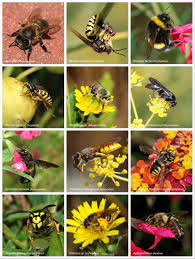

Main elements of this notebook:
1. Transfer learning using **MobileNet V2** model developed at Google
2. Data augmentation
3. Fine tuning

<h3>Importing relevant libraries:

In [ ]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import keras

In [ ]:
path = '/kaggle/input/bee-vs-wasp/kaggle_bee_vs_wasp/'
labels = pd.read_csv(path+'labels.csv')

In [ ]:
labels.head()

In [ ]:
labels.shape

<h3>Dataset composition

In [ ]:
x = list(labels.query('is_validation == 0 & is_final_validation == 0')['label'].unique())
y = list(labels.query('is_validation == 0 & is_final_validation == 0')['label'].value_counts())
x_1 = list(labels.query('is_validation == 1 & is_final_validation == 0')['label'].unique())
y_1 = list(labels.query('is_validation == 1 & is_final_validation == 0')['label'].value_counts())
x_2 = list(labels.query('is_validation == 0 & is_final_validation == 1')['label'].unique())
y_2 = list(labels.query('is_validation == 0 & is_final_validation == 1')['label'].value_counts())
figure, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax1.bar(x,y)
ax1.set_title('Training set value counts')
ax2.bar(x_1,y_1)
ax2.set_title('Validation set value counts')
ax3.bar(x_2,y_2)
ax3.set_title('Test set value counts')
plt.show()

In [ ]:
for i in labels.index:
    labels.loc[i,'path']=labels.loc[i]['path'].replace('\\','/')

<h3>Sample images

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5))
for i in range(5):
    ind = i+random.randint(1,11420)
    img = cv2.imread(path+labels.loc[ind,'path'])
    ax[i].set_title(labels.loc[ind,'label'])
    ax[i].imshow(img) 

In [ ]:
labels.head()

In [ ]:
train_set = labels.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
validation_set = labels.query('is_validation == 1 & is_final_validation == 0').reset_index(drop=True)
test_set = labels.query('is_validation == 0 & is_final_validation == 1').reset_index(drop=True)

<h3>Selecting only high quality images

In [ ]:
def build_data(df, img_size):
    imgs = []
    df = df.query('photo_quality == 1')
    df = df.query('is_bee == 1 | is_wasp ==1')
    for i in df['path']:
        img = cv2.imread(path+i)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(img_size,img_size))
        imgs.append(img)
    imgs = np.array(imgs, dtype='int16')
    imgs = imgs/255
    df = pd.get_dummies(df['label'])
    return imgs, df

img_size = 200
train_imgs, train_df = build_data(train_set, img_size)
val_imgs, val_df = build_data(validation_set, img_size)
test_imgs, test_df = build_data(test_set, img_size)

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(train_imgs[random.randint(0,train_imgs.shape[0]),:,:,:], interpolation='nearest')
ax[1].imshow(val_imgs[random.randint(0,val_imgs.shape[0]),:,:,:], interpolation='nearest')
ax[2].imshow(test_imgs[random.randint(0,test_imgs.shape[0]),:,:,:], interpolation='nearest')
ax[0].set_title('Train_set image sample')
ax[1].set_title('Validation_set image sample')
ax[2].set_title('Test_set image sample')
plt.show()

<h3>Create the base model from the pre-trained convnet

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(200,200,3), include_top=False, weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

<h3>Adding custom top layers

In [ ]:
inputs = tf.keras.Input(shape=(200, 200, 3))
x = inputs
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

<h3>Training

In [ ]:
model.compile(tf.keras.optimizers.Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_imgs, train_df, epochs=10, validation_data=(val_imgs, val_df))

<h3>Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
hist_fine = model.fit(train_imgs, train_df, epochs=10+20, initial_epoch=hist.epoch[-1], validation_data=(val_imgs, val_df))

<h3>Learning curves

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

initial_epochs=10

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h3>Model evaluation

In [ ]:
model.evaluate(test_imgs, test_df)